In [1]:
#pip install pyspark

In [2]:
#conda install -c cyclus java-jdk

In [3]:
#pip install py4j

In [4]:
#load pySpark modules 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "30g") \
    .config('spark.executor.memory=30g')\
    .appName('final') \
    .getOrCreate()
sc=spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/04 21:41:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#.config("spark.driver.memory", "15g") \

In [6]:
#load flight data file into pySpark dataFrame format

flight = spark.read.csv("flights.csv", inferSchema=True, header=True)
airports = spark.read.csv("airports.csv", inferSchema=True, header=True)
flight.show(5)
airports.show(5)


+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|        19|        5|     DL|          11433|        13303|      -3|       1|
|        19|        5|     DL|          14869|        12478|       0|      -8|
|        19|        5|     DL|          14057|        14869|      -4|     -15|
|        19|        5|     DL|          15016|        11433|      28|      24|
|        19|        5|     DL|          11193|        12892|      -6|     -11|
+----------+---------+-------+---------------+-------------+--------+--------+
only showing top 5 rows

+----------+-----------+-----+--------------------+
|airport_id|       city|state|                name|
+----------+-----------+-----+--------------------+
|     10165|Adak Island|   AK|                Adak|
|     10299|  Anchorage|   AK|Ted Stevens Ancho...|
|   

In [7]:
flight.printSchema()

root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)



In [8]:
#load airports data file into pySpark dataFrame format



In [9]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window
#f = flight.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
#a = airports.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

data = flight.join(airports, flight.OriginAirportID == airports.airport_id).drop('airport_id')
data.show(5)

+----------+---------+-------+---------------+-------------+--------+--------+--------------+-----+--------------------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|          city|state|                name|
+----------+---------+-------+---------------+-------------+--------+--------+--------------+-----+--------------------+
|        19|        5|     DL|          11433|        13303|      -3|       1|       Detroit|   MI|Detroit Metro Way...|
|        19|        5|     DL|          14869|        12478|       0|      -8|Salt Lake City|   UT|Salt Lake City In...|
|        19|        5|     DL|          14057|        14869|      -4|     -15|      Portland|   OR|Portland Internat...|
|        19|        5|     DL|          15016|        11433|      28|      24|     St. Louis|   MO|Lambert-St. Louis...|
|        19|        5|     DL|          11193|        12892|      -6|     -11|    Cincinnati|   OH|Cincinnati/Northe...|
+----------+---------+-------+--

In [10]:
data  = data.withColumnRenamed('name', 'OriginAirport').withColumnRenamed('city', 'Origincity').withColumnRenamed('state', 'Originstate')
data.show(5)

+----------+---------+-------+---------------+-------------+--------+--------+--------------+-----------+--------------------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|    Origincity|Originstate|       OriginAirport|
+----------+---------+-------+---------------+-------------+--------+--------+--------------+-----------+--------------------+
|        19|        5|     DL|          11433|        13303|      -3|       1|       Detroit|         MI|Detroit Metro Way...|
|        19|        5|     DL|          14869|        12478|       0|      -8|Salt Lake City|         UT|Salt Lake City In...|
|        19|        5|     DL|          14057|        14869|      -4|     -15|      Portland|         OR|Portland Internat...|
|        19|        5|     DL|          15016|        11433|      28|      24|     St. Louis|         MO|Lambert-St. Louis...|
|        19|        5|     DL|          11193|        12892|      -6|     -11|    Cincinnati|         OH|Cincin

In [11]:
name = airports.withColumnRenamed('name', 'DestAirport').withColumnRenamed('city', 'Destcity').withColumnRenamed('state', 'Deststate')

In [12]:
df = data.join(name, data.DestAirportID == name.airport_id).drop('airport_id')
df.show(5)

+----------+---------+-------+---------------+-------------+--------+--------+--------------+-----------+--------------------+--------------+---------+--------------------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|    Origincity|Originstate|       OriginAirport|      Destcity|Deststate|         DestAirport|
+----------+---------+-------+---------------+-------------+--------+--------+--------------+-----------+--------------------+--------------+---------+--------------------+
|        19|        5|     DL|          11433|        13303|      -3|       1|       Detroit|         MI|Detroit Metro Way...|         Miami|       FL| Miami International|
|        19|        5|     DL|          14869|        12478|       0|      -8|Salt Lake City|         UT|Salt Lake City In...|      New York|       NY|John F. Kennedy I...|
|        19|        5|     DL|          14057|        14869|      -4|     -15|      Portland|         OR|Portland Internat...|Salt Lake

In [13]:
Origincity_count = df.groupby('Origincity').count()
Origincity_count.show(5)

+--------------+-----+
|    Origincity|count|
+--------------+-----+
|       Phoenix|89720|
|         Omaha|13487|
|Raleigh/Durham|28301|
|     Anchorage| 7700|
|        Dallas|19062|
+--------------+-----+
only showing top 5 rows



In [14]:
OriginAirportID_count = df.groupby('OriginAirportID').count()
OriginAirportID_count.show()

+---------------+-----+
|OriginAirportID|count|
+---------------+-----+
|          14570|10344|
|          12264|37429|
|          14771|84276|
|          11057|76465|
|          13830|11346|
|          12191|28963|
|          10529|13042|
|          11259|19062|
|          10800|14170|
|          14831|24310|
|          12889|77878|
|          14730|10915|
|          13303|41948|
|          10140|17542|
|          13342|21002|
|          11278|43107|
|          15304|35149|
|          10792|14797|
|          14524|11485|
|          10423|26982|
+---------------+-----+
only showing top 20 rows



In [15]:
Carrier_count = df.groupby('Carrier').count()
Carrier_count.show()

+-------+------+
|Carrier| count|
+-------+------+
|     UA|286418|
|     AA|289855|
|     EV|157928|
|     B6|121906|
|     DL|381657|
|     OO|160164|
|     F9| 35738|
|     YV| 52821|
|     US|233321|
|     MQ|113212|
|     HA| 17432|
|     AS| 68555|
|     FL| 92702|
|     VX| 34739|
|     WN|575739|
|     9E| 80031|
+-------+------+



In [16]:
#Deal with Duplicate
print("Data All",df.count())
print("Data Distinct", df.dropDuplicates().count())
print("Data Duplicate", df.count()-df.dropDuplicates().count())

Data All 2702218


Data Distinct 2696657


Data Duplicate 5561


In [17]:
print("Data All",airports.count())

Data All 365


In [18]:
#Deal with missing value
flightnomissingvalue=df.dropDuplicates().dropna(how='any').count()
print("Missing Value:",df.count()-flightnomissingvalue)

Missing Value: 5561


In [19]:
df_dis = df.distinct()

In [20]:
df_dis.describe('DepDelay','ArrDelay').show()

+-------+------------------+-----------------+
|summary|          DepDelay|         ArrDelay|
+-------+------------------+-----------------+
|  count|           2696657|          2696657|
|   mean|10.532424034647343|6.668734659246615|
| stddev|36.063715485293585| 38.5861239565741|
|    min|               -63|              -94|
|    max|              1863|             1845|
+-------+------------------+-----------------+



In [21]:
df_f = df_dis.select('DayofMonth','DayOfWeek','Carrier','OriginAirportID','DestAirportID','DepDelay',((col("ArrDelay") > 15).cast("Int").alias("label")))

df_f.show(5)

+----------+---------+-------+---------------+-------------+--------+-----+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|label|
+----------+---------+-------+---------------+-------------+--------+-----+
|         1|        1|     F9|          11292|        10140|      -2|    0|
|         1|        1|     WN|          14107|        10140|       2|    0|
|         8|        1|     WN|          14747|        10140|      13|    0|
|        13|        1|     OO|          12266|        10140|      -6|    0|
|        13|        1|     WN|          12889|        10140|      -5|    0|
+----------+---------+-------+---------------+-------------+--------+-----+
only showing top 5 rows



In [22]:
df_f.printSchema()

root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- label: integer (nullable = true)



In [23]:
numeric_features = [t[0] for t in df_f.dtypes if t[1] == 'int']
df_f.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
DayofMonth,2696657,15.799071591233146,8.801337925743184,1,31
DayOfWeek,2696657,3.9004070595555906,1.9864668165468373,1,7
OriginAirportID,2696657,12742.454167882679,1502.0468528616916,10140,15376
DestAirportID,2696657,12742.858206290233,1502.0033937097596,10140,15376
DepDelay,2696657,10.532424034647343,36.063715485293585,-63,1863
label,2696657,0.1995085025644715,0.39963097876947745,0,1


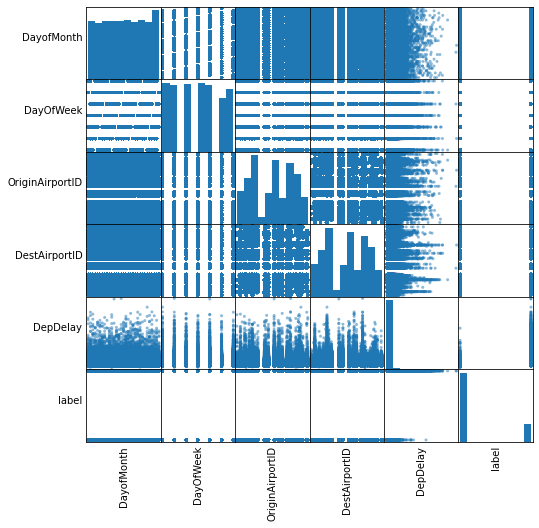

In [24]:
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
numeric_data = df_f.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Target Variable Distribution

In [25]:
df_f.groupby('label').count().show()

22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/05/04 21:48:52 WARN RowBasedKeyValueBatch: Calling spill() on

+-----+-------+
|label|  count|
+-----+-------+
|    1| 538006|
|    0|2158651|
+-----+-------+



### Distribution of Features

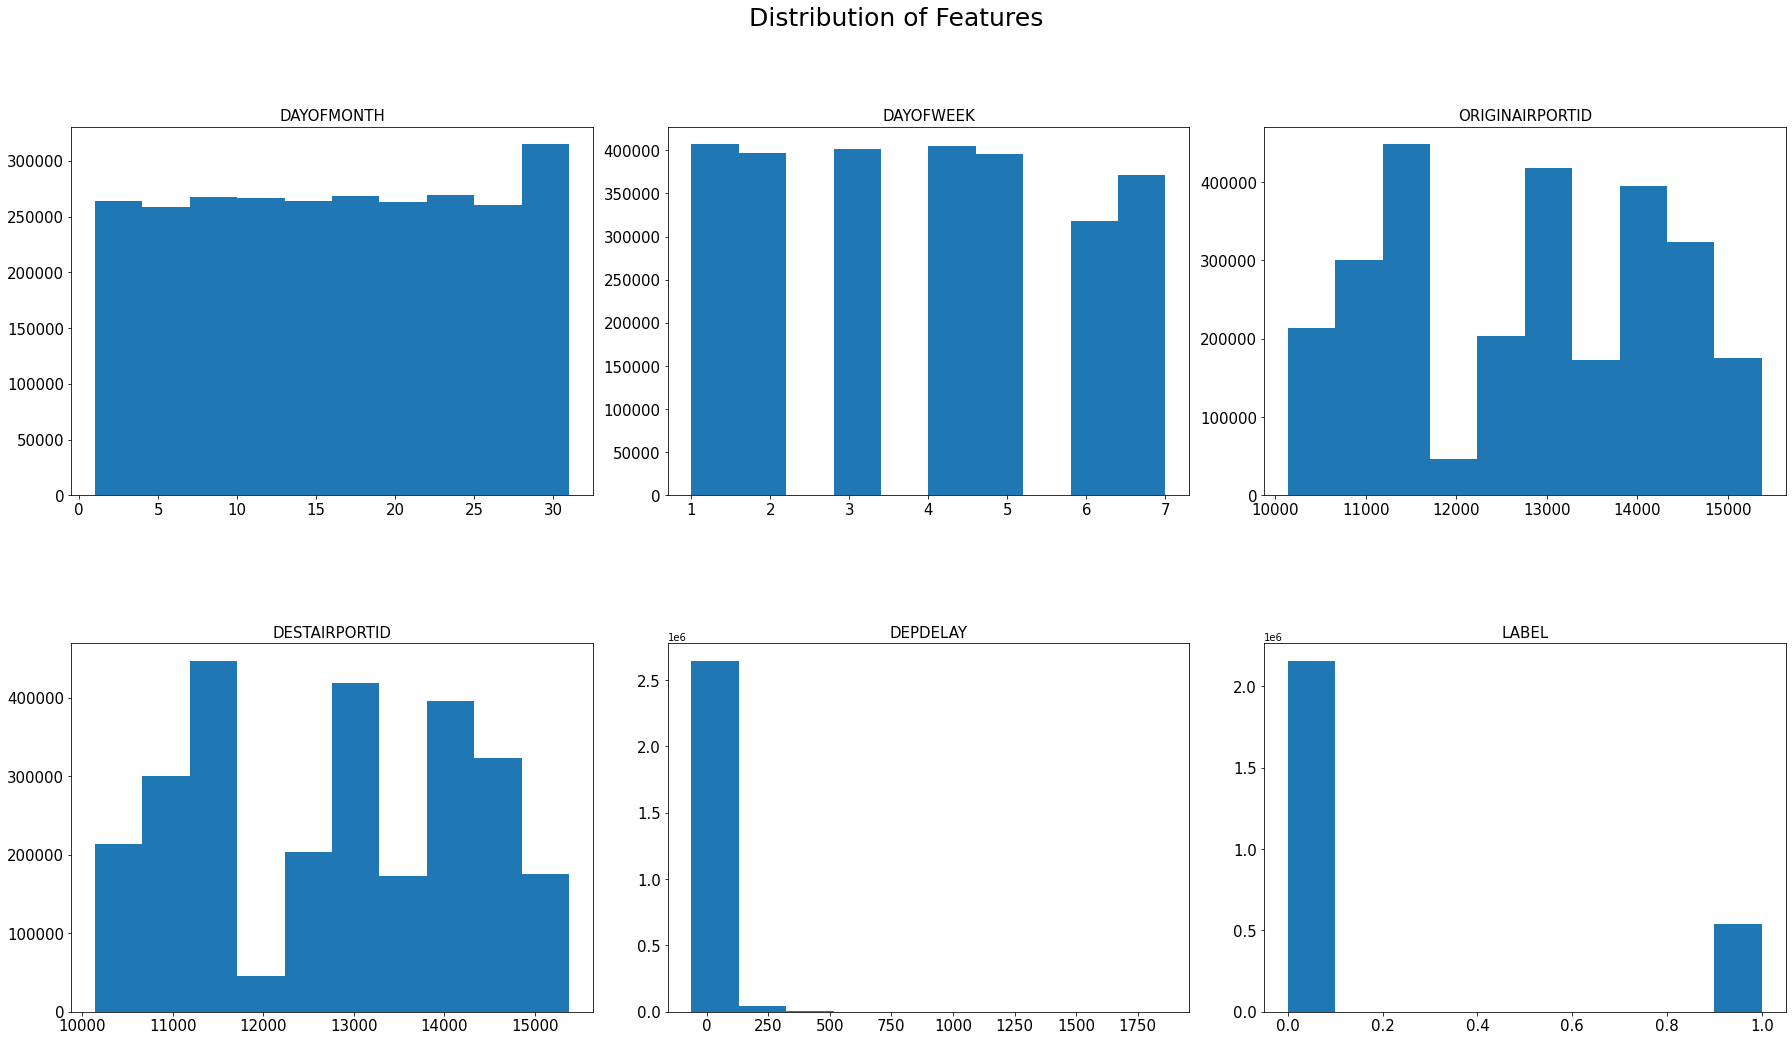

In [26]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=25,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df_f.toPandas().describe().columns, range(1,8)):
    ax = fig.add_subplot(2,3,num)
    ax.hist(df_f.toPandas()[col])
    #plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=15)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [27]:
df_f = df_f.withColumnRenamed("label", "trueLabel")
df_f.show(5)

+----------+---------+-------+---------------+-------------+--------+---------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|trueLabel|
+----------+---------+-------+---------------+-------------+--------+---------+
|         1|        1|     F9|          11292|        10140|      -2|        0|
|         1|        1|     WN|          14107|        10140|       2|        0|
|         8|        1|     WN|          14747|        10140|      13|        0|
|        13|        1|     OO|          12266|        10140|      -6|        0|
|        13|        1|     WN|          12889|        10140|      -5|        0|
+----------+---------+-------+---------------+-------------+--------+---------+
only showing top 5 rows



### Define the Pipeline and split the data 

In [28]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
strIdx = StringIndexer(inputCol = "Carrier", outputCol = "CarrierIdx")
catVect = VectorAssembler(inputCols = ["CarrierIdx", "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "CatFeatures")
numVect = VectorAssembler(inputCols = ["DepDelay"], outputCol="numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["CatFeatures", "normFeatures"], outputCol="features")
label_stringIdx = StringIndexer(inputCol = 'trueLabel', outputCol = 'label')
train, test = df_f.randomSplit([0.8, 0.3], seed = 2018)


### build the logistic regression model

In [29]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter=10,regParam=0.3)

pipeline = Pipeline(stages=[strIdx, catVect, catIdx, numVect, minMax, featVect,label_stringIdx, lr])
#train the model
lrmodel = pipeline.fit(train)

22/05/04 21:52:23 WARN MemoryStore: Not enough space to cache rdd_428_1 in memory! (computed 17.0 MiB so far)
22/05/04 21:52:23 WARN BlockManager: Persisting block rdd_428_1 to disk instead.
22/05/04 21:52:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/04 21:52:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


#### Evaluate our Logistic Regression model.

/Users/bding/Documents/Anaconda/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


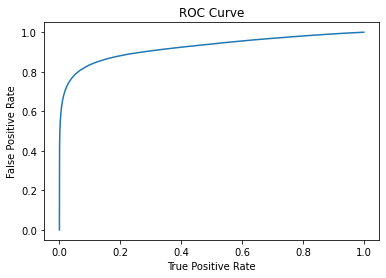

Training set areaUnderROC: 0.9230876647943471


In [30]:
trainingSummary = lrmodel.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/Users/bding/Documents/Anaconda/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


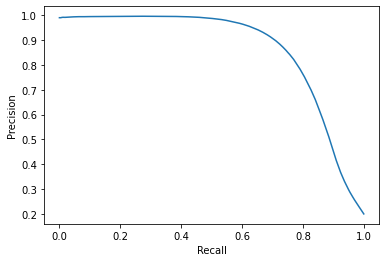

In [31]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [32]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8239628460557584
FPR: 0.7054879809302587
TPR: 0.8239628460557584
F-measure: 0.7633913157400253
Precision: 0.8549054261842692
Recall: 0.8239628460557584


#### Make predictions on the test set

In [ ]:
predictions = lrmodel.transform(test)
predictions_lr = predictions.select("features", "prediction", "trueLabel")
predictions_lr.show(5)
predictions.show(5)

In [34]:
#Evaluating prediction results

tp = float(predictions.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            17358.0|
|       FP|               66.0|
|       TN|           588738.0|
|       FN|           129142.0|
|Precision| 0.9962121212121212|
|   Recall|0.11848464163822525|
|       F1|0.21178106927600598|
+---------+-------------------+



In [48]:
#Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions))

AUC =  0.9221235971359819


In [53]:
from sklearn import metrics
actual =predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()
accuracy = metrics.accuracy_score(actual, predicted)
print('accuracy = ', accuracy)

accuracy =  0.8242794816837662


/var/folders/gw/yh0lqvkx31988_00fxgrp7680000gn/T/ipykernel_9196/726484985.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


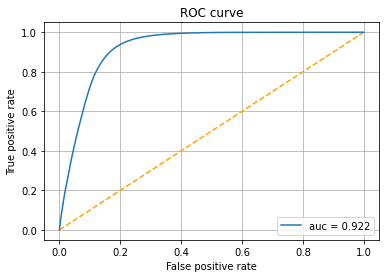

In [56]:
import numpy as np
import matplotlib.pyplot as plt
pred_pd_full = predictions.select(['label', 'prediction', 'probability']).toPandas()
pred_pd_full['probability'] = pred_pd_full['probability'].map(lambda x: list(x))
pred_pd_full['encoded_label'] = pred_pd_full['label'].map(lambda x: np.eye(2)[int(x)])

y_pred = np.array(pred_pd_full['probability'].tolist())
y_true = np.array(pred_pd_full['encoded_label'].tolist())
from sklearn.metrics import auc, roc_curve
fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)


plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Tune Parameters

In [37]:
import time
t1 = time.time()
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.1]).addGrid(lr.maxIter, [10, 5]).addGrid(lr.threshold, 
                                                                                            [0.4, 0.3]).build()
cv = CrossValidator(estimator=pipeline, evaluator=BinaryClassificationEvaluator(), estimatorParamMaps=paramGrid, 
                    numFolds=2)

model = cv.fit(train)
t2 = time.time()
print(t2-t1)

22/05/04 22:40:25 WARN MemoryStore: Not enough space to cache rdd_2882_3 in memory! (computed 17.0 MiB so far)
22/05/04 22:40:25 WARN BlockManager: Persisting block rdd_2882_3 to disk instead.


2713.298790216446


In [40]:
%%time
model = cv.fit(train)

22/05/05 00:29:30 WARN MemoryStore: Not enough space to cache rdd_5153_0 in memory! (computed 17.0 MiB so far)
22/05/05 00:29:30 WARN BlockManager: Persisting block rdd_5153_0 to disk instead.


CPU times: user 3.33 s, sys: 1.22 s, total: 4.55 s
Wall time: 2h 38min 57s


In [43]:
newprediction = model.transform(test)
newPredicted = newprediction.select("features", "prediction", "trueLabel")
newPredicted.show()

+--------------------+----------+---------+
|            features|prediction|trueLabel|
+--------------------+----------+---------+
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,104...|       1.0|        1|
|[10.0,1.0,0.0,105...|       0.0|        1|
|[10.0,1.0,0.0,107...|       0.0|        1|
|[10.0,1.0,0.0,108...|       0.0|        0|
|[10.0,1.0,0.0,108...|       1.0|        1|
|[10.0,1.0,0.0,110...|       0.0|        0|
|[10.0,1.0,0.0,110...|       0.0|        0|
|[10.0,1.0,0.0,111...|       1.0|        1|
|[10.0,1.0,0.0,111...|       0.0|        1|
|[10.0,1.0,0.0,111...|       0.0|        0|
|[10.0,1.0,0.0,111...|       0.0|        0|
|[10.0,1.0,0.0,111...|       0.0|        0|
|[10.0,1.0,0.0,111...|       0.0|        0|
|[10.0,1.0,0.0,111...|       0.0|        0|
|[10.0,1.0,0.0,114...|       0.0|        0|
|[10.0,1.0,0.0,114...|       0.0|        0|
|[10.0,1.0,0.0,114...|       0.0|        0|
|[10.0,1.0,0.0,114...|       0.0|        0|
|[10.0,1.0,0.0,114...|       0.0

In [44]:
# Recalculate confusion matrix
tp2 = float(newPrediction.filter("prediction == 1.0 AND truelabel == 1").count())
fp2 = float(newPrediction.filter("prediction == 1.0 AND truelabel == 0").count())
tn2 = float(newPrediction.filter("prediction == 0.0 AND truelabel == 0").count())
fn2 = float(newPrediction.filter("prediction == 0.0 AND truelabel == 1").count())
pr2 = tp2 / (tp2 + fp2)
re2 = tp2 / (tp2 + fn2)
metrics2 = spark.createDataFrame([
 ("TP", tp2),
 ("FP", fp2),
 ("TN", tn2),
 ("FN", fn2),
 ("Precision", pr2),
 ("Recall", re2),
 ("F1", 2*pr2*re2/(re2+pr2))],["metric", "value"])
metrics2.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|           79827.0|
|       FP|            1594.0|
|       TN|          587210.0|
|       FN|           66673.0|
|Precision|0.9804227410618882|
|   Recall|0.5448941979522184|
|       F1|0.7004795521255172|
+---------+------------------+



In [46]:
# Recalculate the Area Under ROC
evaluator2 = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
aur2 = evaluator.evaluate(newprediction)
print( "AUR2 = ", aur2)

AUR2 =  0.9225255563467313


In [55]:
actual =newprediction.select('label').toPandas()
predicted = newprediction.select('prediction').toPandas()
accuracy_new = metrics.accuracy_score(actual, predicted)
print('accuracy = ', accuracy)

accuracy =  0.8242794816837662


In [ ]:
sc.stop()